## Setup

In [2]:
from ast import literal_eval
import functools
import json
import os
import random
import re


# Scienfitic packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
torch.set_grad_enabled(False)
tqdm.pandas()

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook", 
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities
from utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)
import nethook
# List of stopwords from NLTK, needed only for the attributes rate evaluation.
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopwords0_ = stopwords.words('english')
# stopwords0_ = {word: "" for word in stopwords0_}

/17119/miniconda3/envs/kssam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
knowns_df = pd.read_json("../edit/data/known_1000.json")
knowns_df_size = len(knowns_df)

# GPT-J

In [6]:

# Load model from local
model_path = "/17119/stu/ptms/"
model_name = "Llama-2-7b-hf"
mt = ModelAndTokenizer(
    model_path,
    model_name,
    low_cpu_mem_usage=False,
    # torch_dtype=torch.half,
)
mt.model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [01:29<00:00, 44.90s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

## Cache of hidden representations of GPT-J

In [7]:
# create a cache of subject representations
def edit_output_fn(cur_out, cur_layer):
    return cur_out
E = mt.model.get_output_embeddings().weight.detach()

# Llama2
ln_f = nethook.get_module(mt.model, "model.norm")
mlp_module_tmp = "model.layers.{}.mlp"
attn_module_tmp = "model.layers.{}.self_attn"
layers_to_cache = range(0,32)

#GPT-J
# ln_f = nethook.get_module(mt.model, "transformer.ln_f")
# mlp_module_tmp = "transformer.h.{}.mlp"
# attn_module_tmp = "transformer.h.{}.attn"
# layers_to_cache = range(0,28)

layers_to_trace = []

# 使用for循环将layers_to_cache列表中的每个层添加到要追踪的列表中
for layer in layers_to_cache:
    layers_to_trace.append(mlp_module_tmp.format(layer))
    layers_to_trace.append(attn_module_tmp.format(layer))

hs_cache = {}
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    inp = make_inputs(mt.tokenizer, [prompt])
    
    with nethook.TraceDict(
        module=mt.model,
        layers=layers_to_trace,
        retain_input=True,
        retain_output=True,
        detach=True
    ) as tr:
        logits = mt.model(**inp).logits
        predicted_token_index  = torch.argmax(torch.softmax(logits[:, -1, :], dim=-1), dim=-1)[0]
        last_input = None
        for layer in layers_to_trace:
            if (prompt, layer) not in hs_cache:
                hs_cache[(layer, prompt)] = {}
                hs_cache[(layer,prompt)]['states'] = []
                hs_cache[(layer,prompt)]['probs'] = []
            
            if 'attn' in layer:
                hs_cache[(layer,prompt)]['states'].append(last_input)
                hs_cache[(layer,prompt)]['states'].append(tr[layer].output[0][0] )
            else:
                last_input = tr[layer].input[0]
                hs_cache[(layer,prompt)]['states'].append(last_input)
                hs_cache[(layer,prompt)]['states'].append(tr[layer].output[0])
            #compute attribute probs
            hs_cache[(layer, prompt)]['probs'] = []
            for i in range(2):
                if i==1:
                    full_repr = hs_cache[(layer,prompt)]['states'][i]+last_input
                else:
                    full_repr = hs_cache[(layer,prompt)]['states'][i]
                log_probs = torch.softmax(ln_f(full_repr) @ E.T, dim = -1)
                try:
                    attr_log_probs = log_probs[-1, predicted_token_index]
                except:
                    attr_log_probs = log_probs.squeeze(0)[-1, predicted_token_index]
                hs_cache[(layer, prompt)]['probs'].append(attr_log_probs.item())
        
len(hs_cache)

1209it [03:09,  6.38it/s]


77312

## Get sentence representations' similarities

In [8]:
# Projection of token representations
E = mt.model.get_input_embeddings().weight.detach()
k = 50

def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union
records = []
all_probs = {}
all_cos_sim_attn = [0 for l in layers_to_cache]
all_cos_sim_mlp = [0 for l in layers_to_cache]
all_jac_sim_attn = [0 for l in layers_to_cache]
all_jac_sim_mlp = [0 for l in layers_to_cache]
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    for layer in layers_to_trace:
        layer_num = int(re.findall("\d+", layer)[0])
        if layer not in all_probs:
            all_probs[layer] = [0, 0]
        if (layer,prompt) in hs_cache:
            all_probs[layer][0] += hs_cache[(layer,prompt)]['probs'][0]
            all_probs[layer][1] += hs_cache[(layer,prompt)]['probs'][1]
        position, desc = (len(inp["input_ids"][0])-1, f"no_subj_last_{layer}")
        in_hs = hs_cache[(layer,prompt)]['states'][0][position]
        try:
            ot_hs = hs_cache[(layer,prompt)]['states'][1][position]
        except:
            ot_hs = hs_cache[(layer,prompt)]['states'][1].squeeze(0)[position]
        in_projs = in_hs.matmul(E.T).cpu().numpy()
        ot_projs = ot_hs.matmul(E.T).cpu().numpy()
        in_ind = np.argsort(-in_projs)
        ot_ind = np.argsort(-ot_projs)
        in_topks = [decode_tokens(mt.tokenizer, [i])[0] for i in in_ind[:k]]
        ot_topks = [decode_tokens(mt.tokenizer, [i])[0] for i in ot_ind[:k]]
        
        if "mlp" in layer:
            all_cos_sim_mlp[layer_num] += torch.cosine_similarity(in_hs, ot_hs, dim = 0).cpu()
            all_jac_sim_mlp[layer_num] += jaccard_set(in_topks, ot_topks)
        else:
            all_cos_sim_attn[layer_num] += torch.cosine_similarity(in_hs, ot_hs, dim = 0).cpu()
            all_jac_sim_attn[layer_num] += jaccard_set(in_topks, ot_topks)
        records.append({
            "example_index": row_i,
            "subject": subject,
            "layer": layer,
            "position": position,
            "desc": desc,
            "desc_short": desc.rsplit("_", 1)[0],
            "input_top_k_preds": in_topks,
            "output_top_k_preds": ot_topks,
        })

tmp = pd.DataFrame.from_records(records)

1209it [09:01,  2.23it/s]


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

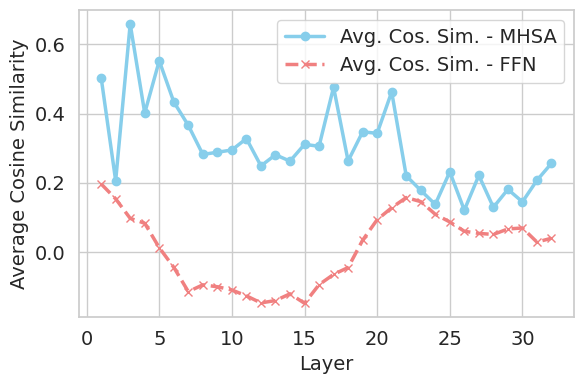

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

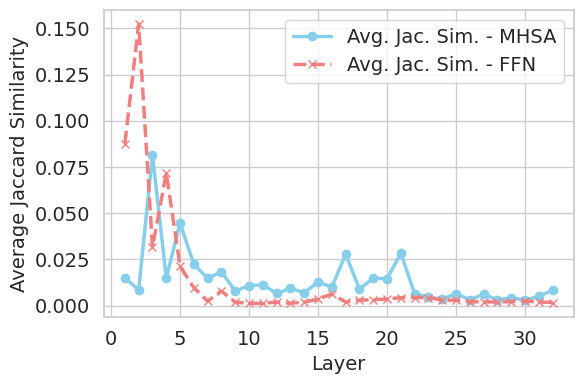

In [9]:
def plot_sim(layers_to_cache, ylabel, all_sim_attn, attn_label, all_sim_mlp, mlp_label, save_path=None):
    layers_to_cache = [layer+1 for layer in layers_to_cache]
    _, ax = plt.subplots(figsize=(6, 4))
    
    # Choose light colors for the lines
    attn_color = 'skyblue'
    mlp_color = 'lightcoral'
    
    # Plot attention similarity
    plt.plot(layers_to_cache, np.array(all_sim_attn) / knowns_df_size, label=attn_label, color=attn_color, linestyle='-', marker='o', linewidth=2.5)
    
    # Plot MLP similarity
    plt.plot(layers_to_cache, np.array(all_sim_mlp) / knowns_df_size, label=mlp_label, color=mlp_color, linestyle='--', marker='x', linewidth=2.5)
    
    plt.tick_params(labelsize=14)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    plt.xlabel('Layer', font1)
    plt.ylabel(ylabel, font1)
    plt.legend(loc='best', prop=font1)
    plt.grid(True)
    plt.tight_layout()  # Ensures all elements fit nicely in the plot area
    
    if save_path:
        plt.savefig(save_path, format='pdf')  # Save the plot as PDF file if the 'save_path' parameter is provided
    else:
        plt.show()


font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}
plot_sim(layers_to_cache, 'Average Cosine Similarity', all_cos_sim_attn,'Avg. Cos. Sim. - MHSA', all_cos_sim_mlp, 'Avg. Cos. Sim. - FFN', "cos_sim.pdf")
plot_sim(layers_to_cache, 'Average Jaccard Similarity', all_jac_sim_attn,'Avg. Jac. Sim. - MHSA',all_jac_sim_mlp, 'Avg. Jac. Sim. - FFN', "jac_sim.pdf")